# Robotic Arm - Panda Gym 

In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from td3_algo import TD3Trainer

* Robot: Simulates the Franka Emika Panda robotic arm for manipulation tasks.
<br>

* Observation Space:
    - All tasks include gripper position and velocity (6 values).
    - Tasks involving objects include their position, orientation, and velocities (linear and rotational, 12 values per object).
    - Gripper opening (distance between fingers) is included if not constrained closed (1 value).

* Action Space:
    - Gripper movement commands (3 values for x, y, and z axes).
    - Gripper opening/closing command (1 value).
    
* Simulation Details:
    - Simulation runs 20 timesteps per agent action (2ms each).
    - Overall interaction frequency is 25Hz.
    - Most tasks have episodes lasting 2 seconds (50 interactions).
    
* Reward Function:
    - Default reward is sparse: 0 for successful completion (within 5cm tolerance), -1 otherwise.
    - Sparse rewards are simpler to define but lack information on progress.

# PandaReach-v3

* Task: A target position must be reached with the gripper. This target position is randomly generated in a volume of 30 cm × 30 cm × 30 cm

In [2]:
env = gym.make(
    "PandaReach-v3",
    render_mode="rgb_array",
    renderer="OpenGL",
    render_target_position=[0, 0.15, 0.25],
    render_distance=0.85,
    render_yaw=135,
    render_pitch=-20,
)

pybullet build time: Dec  5 2025 16:32:26


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=0.8745098114013672
argv[2] = --background_color_green=0.21176470816135406
argv[3] = --background_color_blue=0.1764705926179886
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 20.1.2, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 20.1.2, 256 bits)
b3Print


Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

Action Space:  Box(-1.0, 1.0, (3,), float32)

Initial State:  ({'observation': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00], dtype=float32), 'achieved_goal': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01], dtype=float32), 'desired_goal': array([ 0.01337071, -0.09823571,  0.15232113], dtype=float32)}, {'is_success': array(False)})

A step in the environment:  ({'observation': array([0.05612974, 0.02471757, 0.20918499, 0.54309   , 1.1585152 ,
       0.51952785], dtype=float32), 'achieved_goal': array([0.05612974, 0.02471757, 0.20918499], dtype=float32), 'desired_goal': array([ 0.01337071, -0.09823571,  0.15232113], dtype=float32)}, -1.0, False, False, {'is_success': False})


Rendered Environment: 


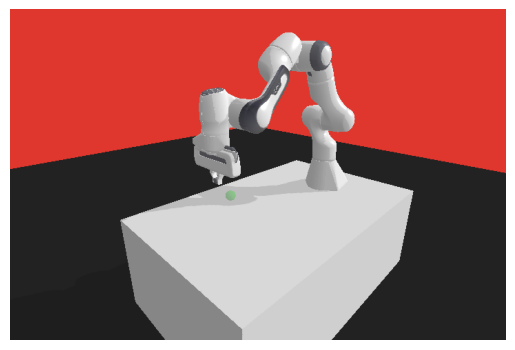

In [3]:
print('\nObservation Space:', env.observation_space)
print('\nAction Space: ', env.action_space)
print('\nInitial State: ',env.reset())
print('\nA step in the environment: ', env.step(np.array(1.0)))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render())
plt.show()

In [4]:
obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]

# Training - Obtain Expert Policy

1. **Initialization**:
   - Set hyperparameters, and initialize actor annd critic networks.
   - Initialize replay buffer memory.

2. **Training Loop**:
   - Loop through a specified number of episodes:
     - Reset the environment to get the initial observation.
     - While the episode is not done:
       - Select an action using the actor network with exploration noise.
       - Execute the action in the environment and observe the next state and reward.
       - Store the experience (state, action, reward, next_state, done) in the replay buffer.
       - Perform HER augmentation on the replay buffer.
       - Sample a batch of experiences from the replay buffer.
       - Optimize the critic networks:
         - Compute target Q-values using the target critic networks.
         - Compute critic losses and perform gradient descent.
       - Update the actor network:
         - Compute actor loss and perform gradient descent.
         - Update the target actor network using a soft update rule.
       - Update the target critic networks using a soft update rule.

3. **HER Augmentation**:
   - For each sample in the replay buffer, apply Hindsight Experience Replay by randomly sampling future states and goals.
   - Store the augmented experiences in the replay buffer.

4. **Optimize Model**:
   - If enough experiences are available in the replay buffer:
     - Sample a batch of experiences.
     - Compute target Q-values for both critic networks.
     - Compute critic losses and perform gradient descent.
     - If it's time to update the actor:
       - Compute actor loss and perform gradient descent.
       - Update the target actor network.
     - Update the target critic networks.

5. **Significance of Two Critic Networks**:
   - Having two critic networks helps reduce overestimation bias in the estimated Q-values. During optimization, the minimum Q-value of the two critic networks is used to compute the target value, which leads to more stable and accurate updates.
   - The use of two critic networks also increases robustness against overfitting and helps prevent the agent from getting stuck in local minima during training.

In [5]:
expert = TD3Trainer(env=env, input_dims=obs_shape, agent_name='Expert', model_save_path='./Models/Expert/', 
                    exploration_period=300)

Training..:   1%|          | 6/500 [00:01<01:28,  5.58it/s]/home/shimoiyusuke/manipulator-inverse-rl/TD3/td3_algo.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([observation], dtype=torch.float32).to(self.device)
Training..:  20%|██        | 102/500 [00:18<00:58,  6.79it/s]

Episode: 100 	 Steps: 4 	 Score: -3.0 	 Average score: -41.8


Training..:  40%|████      | 202/500 [00:30<00:25, 11.60it/s]

Episode: 200 	 Steps: 3 	 Score: -2.0 	 Average score: -14.1


Training..:  60%|██████    | 302/500 [00:38<00:16, 12.08it/s]

Episode: 300 	 Steps: 4 	 Score: -3.0 	 Average score: -2.7


Training..:  80%|████████  | 402/500 [00:47<00:08, 12.13it/s]

Episode: 400 	 Steps: 2 	 Score: -1.0 	 Average score: -1.9


Training..: 100%|██████████| 500/500 [00:55<00:00,  9.04it/s]


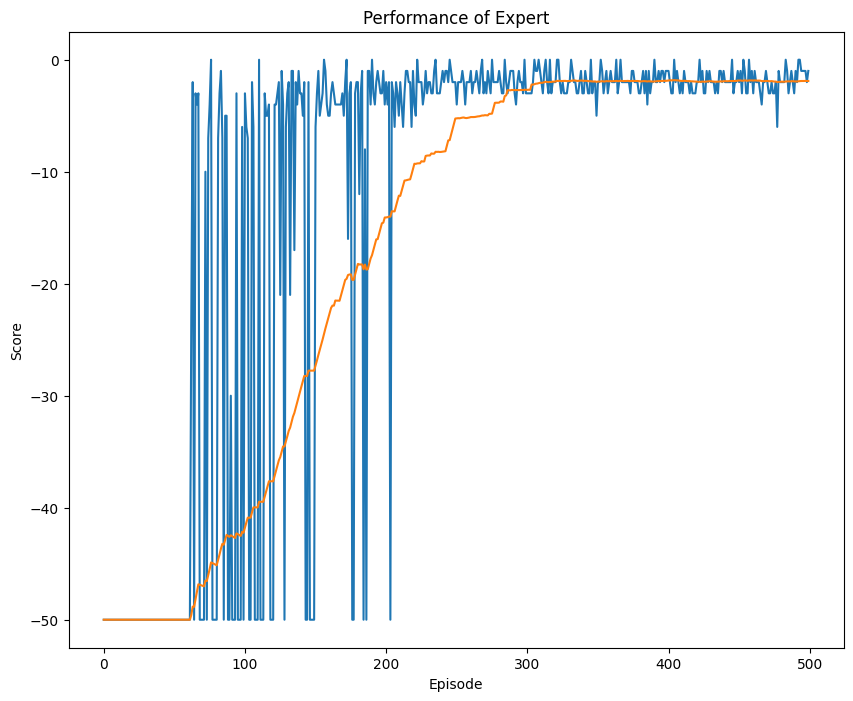

In [6]:
score_history, avg_score_history = expert.td3_train(n_episodes=500, opt_steps=10, print_every=100,
                                                    plot_save_path='../Results/TD3/Expert Performance.png')

In [7]:
expert.save_model()

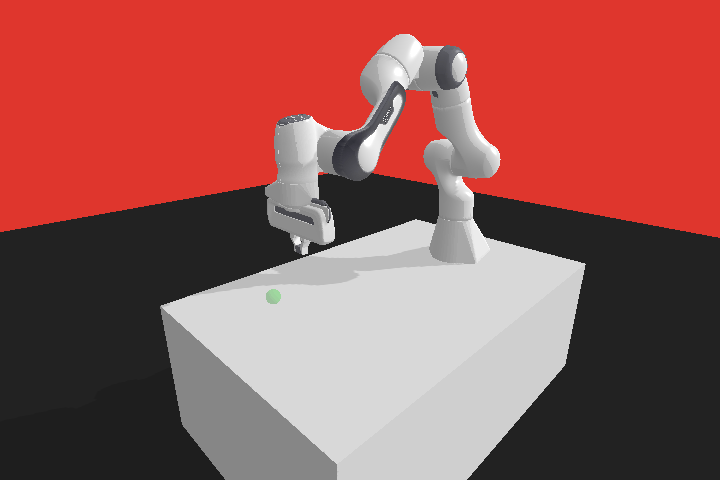

Expert Reward:  -2.0


In [8]:
expert_reward = expert.test_model(env=env, steps=100, render_save_path='../Results/TD3/Expert Policy', fps=5)
print('Expert Reward: ', expert_reward)

# IRL Algorithm

* To train new agents, instead of utilizing the (predefined) returned reward from the training environment, it incorporates the reward function of the expert derived from the IRL algorithm. This reward function involves a weight term (w) and observation space (Φ(s)) obtained through the IRL algorithm.

* Feature Expectations (µ(π)): The expected discounted accumulated feature vector for a policy π (captures the long-term effects of a policy on state features).

* We can estimate the expert's feature expectations (µE) from observed monte carlo trajectories.

* The empirical estimate for µE = µ(πE) based on a set of m observed expert trajectories is given by:

$$µ̂_E = \frac{1}{m} ∑_m ∑_t (γ^t * φ(ŝ(i)_t))$$

In [9]:
expert = TD3Trainer(env=env, input_dims=obs_shape, agent_name='Expert', model_load_path='./Models/Expert/')

In [10]:
def compute_average_feature(agent, m=2000):
        """
        Calculate average feature vector (feature expectation) and average reward over m episodes.
        """
        with torch.inference_mode():
            feature_sum, reward_sum = None, None

            for i in tqdm(range(m), desc='Calculating Average Feature Vector and Reward'):
                reward, states = agent.test_model(steps=1000, save_states=True)

                # mean feature vector across the episode
                episode_mean = torch.stack(states).mean(0)

                if feature_sum is None:
                    feature_sum, reward_sum = episode_mean, reward
                else:
                    feature_sum += episode_mean
                    reward_sum += reward

            # µ̂E = (1/m) ∑_m ∑_t (γ^t φ(ŝ(i)_t))  where γ ≈ 1
            feature_sum /= m
            reward_sum /= m

            print('\nFeature Expectation: ',feature_sum)
            print('\nAverage Reward: ',reward_sum)

        return feature_sum, reward_sum

In [11]:
expert_feature_expectation, expert_mean_reward = compute_average_feature(expert, m=1000)   # µ_E

Calculating Average Feature Vector and Reward:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating Average Feature Vector and Reward: 100%|██████████| 1000/1000 [00:25<00:00, 38.74it/s]



Feature Expectation:  tensor([[ 0.0231, -0.0009,  0.1751, -0.1946,  0.0097, -0.2533,  0.0231, -0.0009,
          0.1751, -0.0011, -0.0024,  0.1543]], device='cuda:0')

Average Reward:  -1.86


## IRL algorithm using Projection method

1. **Initialization:**
   - Randomly pick an initial policy, denoted as π(0).
   - Compute the feature expectation, µ(0), using Monte Carlo or other approximation methods.
   - Set iteration counter i = 1.

2. **Margin Computation:**
   - Compute the margin, t(i), as the maximum margin between the current feature expectation and those of previous policies.
   - Compute margin using projection method to find the optimal weight vector w(i).

3. **Termination Check:**
   - If the margin t(i) is less than or equal to a predefined threshold ε, terminate the algorithm.

4. **IRL Training:**
   - Use a Reinforcement Learning (RL) algorithm to compute the optimal policy π(i) for the Markov Decision Process (MDP) with rewards defined by the weight vector w(i).

5. **Update Feature Expectation:**
   - Compute or estimate the feature expectation, µ(i), based on the new policy π(i).

6. **Iteration Update:**
   - Increment the iteration counter i.

7. **Repeat:**
   - Return to step 2 and iterate through the process until the termination condition is met.

Upon termination, the algorithm returns a set of policies {π(i) : i = 0 . . . n}, representing a sequence of policies that approximate the expert's behavior.

In [12]:
def projection_method_algorithm(env, epsilon=0.001, m=2000, n_episodes=100,
                                opt_steps=10, exploration_period=100, save_render=True, fps=5):
    
    feature_expectation = []
    feature_expectation_bar = []
    weights = []
    margins = []
    rewards = []
    obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]
    train_another = ''

    for i in range(100):
        print(f"\n-------------------------------------- Iteration: {i} --------------------------------------\n")
        apprentice = TD3Trainer(env=env, input_dims=obs_shape, agent_name=f'Apprentice {i}', 
                                model_save_path=f'./Models/Apprentice {i}/', 
                                exploration_period=exploration_period)

        # Step 1: Initialization
        if i == 0:
            observation, info = env.reset()
            current_observation, current_achieved_goal, current_desired_goal = observation.values()
            state = np.concatenate((current_observation, current_achieved_goal, current_desired_goal))
            sample_feature = torch.tensor(state, dtype=torch.float32)
            
            w_0 = torch.randn(sample_feature.size(0), 1).div_(torch.randn(1).norm())
            weights.append(w_0)
            apprentice.td3_train(n_episodes=n_episodes, opt_steps=opt_steps, 
                                 reward_weights=w_0, print_every=n_episodes+1, 
                                 plot_save_path=f'../Results/TD3/Apprentice_{i} Performance.png')
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)
            
            rewards.append(apprentice_reward)
            margins.append(1)
            feature_expectation.append(apprentice_feature_expectation)
            
            print("Expert Feature Expectation:", expert_feature_expectation)
            
        else:
            # Step 2: IRL
            # First iteration of step 2 of algorithm
            if i == 1:
                feature_expectation_bar.append(feature_expectation[i - 1])       # µ¯^(0) = µ^(0)
                weights.append((expert_feature_expectation - feature_expectation[i - 1]).view(-1, 1))   # w^(1) = µ_E - µ^(0)
                margins.append((expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item())
                print("Weight:", weights[i])
                print("Margin:", margins[i])

            # Iterations 2 and onward of step 2 of algorithm
            else:
                A = feature_expectation_bar[i - 2]              # µ¯(i−2)
                B = feature_expectation[i - 1] - A              # (µ(i−1) − µ¯(i−2))
                C = expert_feature_expectation - A              # µ_E − µ¯(i−2)

                feature_expectation_bar.append(A + ((B.view(-1, 1).t() @ C.view(-1, 1)) / \
                                                    (B.view(-1, 1).t() @ B.view(-1, 1))) * B)  # projection method step

                # w(i) = µ_E − μ¯(i−1)
                weight = (expert_feature_expectation - feature_expectation_bar[i - 1]).view(-1, 1)

                # t(i) = ∥µ_E − µ¯(i−1)∥_2
                margin = (expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item()
                
                weights.append(weight)
                margins.append(margin)
                
                print("Margin:", margins[i])
                print("Weight:", weights[i])
                
                train_another = input('Train another apprentice agent? (y/n): ').lower()

            # Step 3: Termination condition
            if margins[i] <= epsilon or train_another=='n':   # terminate with margin ≤ ∈ (or no. of iterations)
                break

            # Step 4: IRL training
            apprentice.td3_train(n_episodes=n_episodes, opt_steps=opt_steps, 
                                 reward_weights=weights[-1], print_every=n_episodes+1, 
                                 plot_save_path=f'../Results/TD3/Apprentice_{i} Performance.png')
            apprentice.save_model()
            
            if save_render:
                apprentice_reward = apprentice.test_model(steps=1000, render_save_path=f'../Results/TD3/Apprentice {i} Policy', fps=fps)
                print(f'{apprentice.agent_name} Reward: ', apprentice_reward)

            # Step 5: Update feature expectation
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)
            rewards.append(apprentice_reward)
            feature_expectation.append(apprentice_feature_expectation)

        print("")
        
    return rewards, margins


-------------------------------------- Iteration: 0 --------------------------------------



Training..: 100%|██████████| 400/400 [01:37<00:00,  4.10it/s]


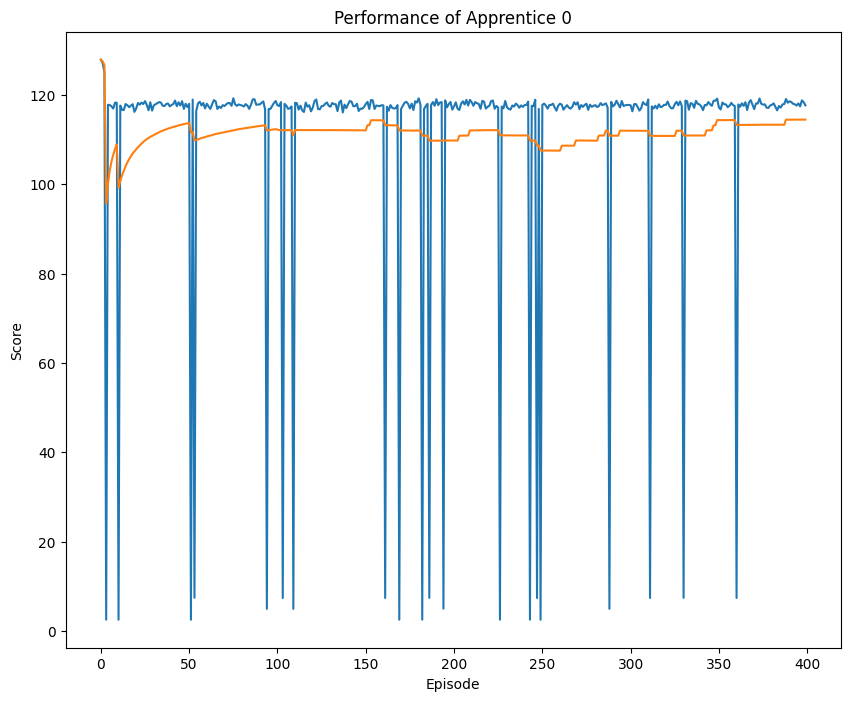

Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:47<00:00, 10.49it/s]



Feature Expectation:  tensor([[-0.6595,  0.4095,  0.5292, -0.2744,  0.1823,  0.1633, -0.6595,  0.4095,
          0.5292,  0.0050,  0.0050,  0.1560]], device='cuda:0')

Average Reward:  -47.154
Expert Feature Expectation: tensor([[ 0.0231, -0.0009,  0.1751, -0.1946,  0.0097, -0.2533,  0.0231, -0.0009,
          0.1751, -0.0011, -0.0024,  0.1543]], device='cuda:0')


-------------------------------------- Iteration: 1 --------------------------------------

Weight: tensor([[ 0.6826],
        [-0.4104],
        [-0.3541],
        [ 0.0798],
        [-0.1726],
        [-0.4166],
        [ 0.6826],
        [-0.4104],
        [-0.3541],
        [-0.0061],
        [-0.0074],
        [-0.0017]], device='cuda:0')
Margin: 1.3150177001953125


Training..: 100%|██████████| 400/400 [00:50<00:00,  7.95it/s]


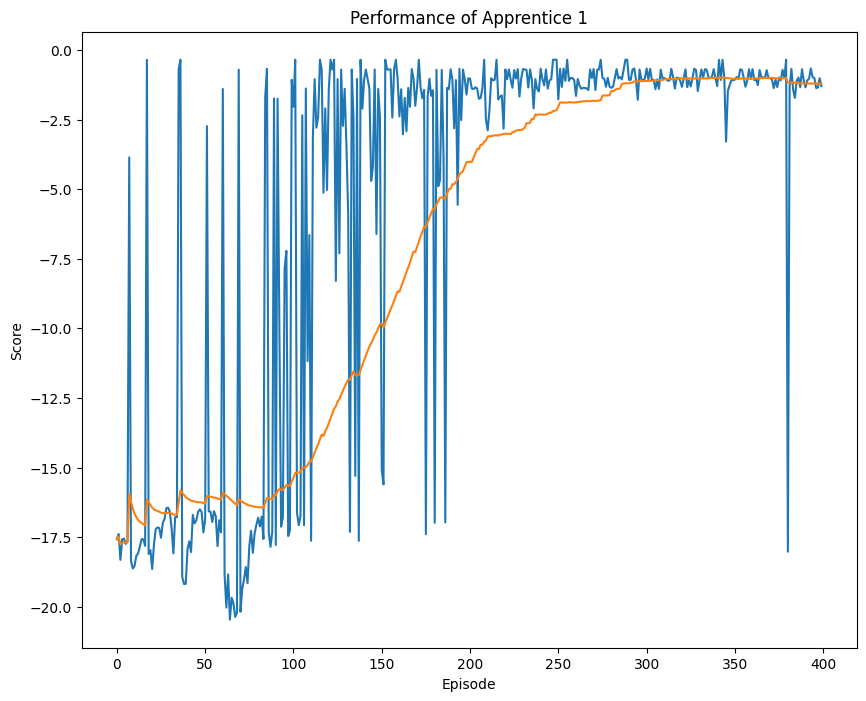

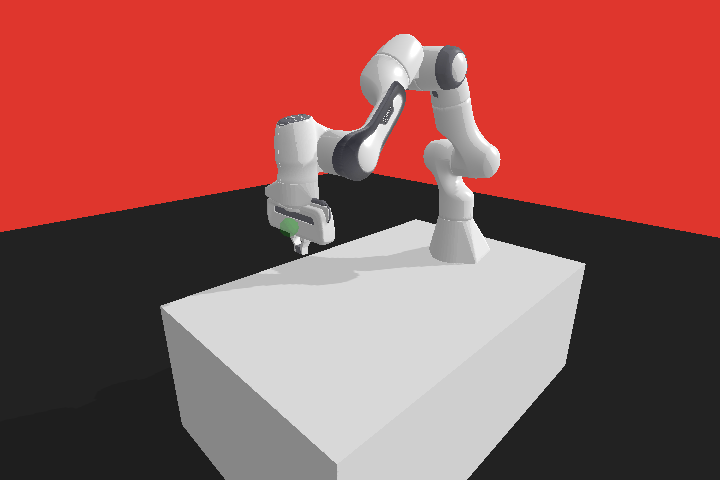

Apprentice 1 Reward:  -1.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 37.99it/s]


Feature Expectation:  tensor([[ 0.0235,  0.0030,  0.1743, -0.1982,  0.0107, -0.2399,  0.0235,  0.0030,
          0.1743, -0.0028,  0.0061,  0.1516]], device='cuda:0')

Average Reward:  -1.872


-------------------------------------- Iteration: 2 --------------------------------------

Margin: 0.01651611551642418
Weight: tensor([[-0.0035],
        [-0.0020],
        [ 0.0024],
        [ 0.0032],
        [-0.0002],
        [-0.0116],
        [-0.0035],
        [-0.0020],
        [ 0.0024],
        [ 0.0018],
        [-0.0085],
        [ 0.0027]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:04<00:00,  6.24it/s]


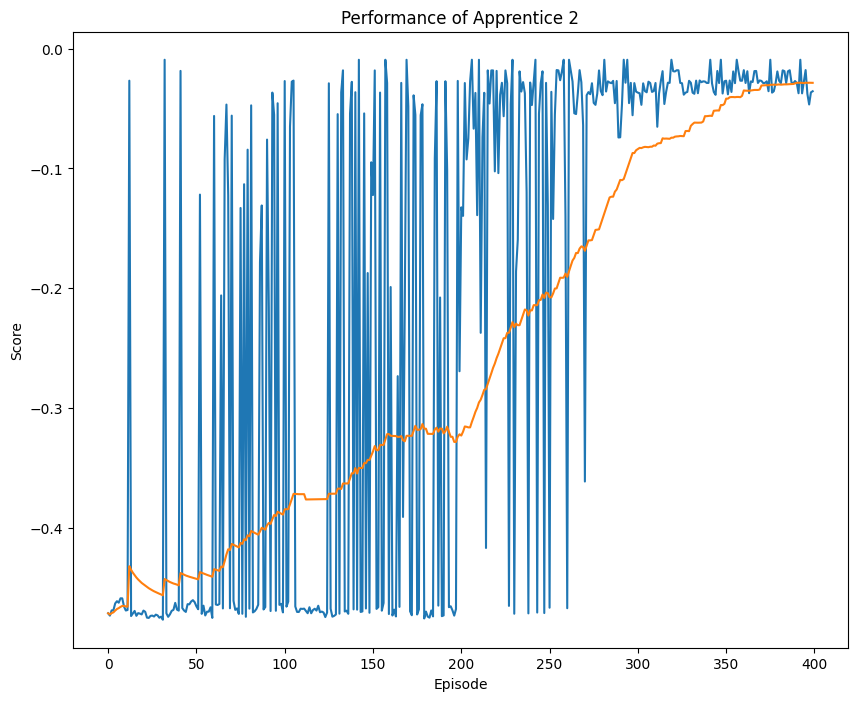

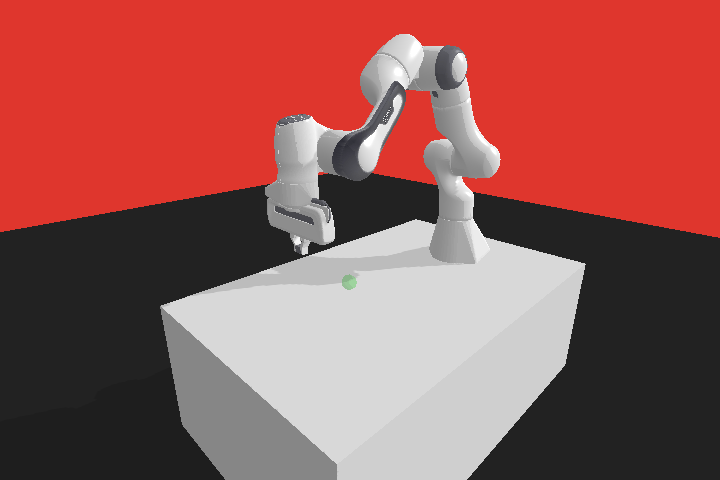

Apprentice 2 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 36.07it/s]



Feature Expectation:  tensor([[ 0.0245,  0.0014,  0.1802, -0.1675,  0.0200, -0.2096,  0.0245,  0.0014,
          0.1802, -0.0003,  0.0009,  0.1543]], device='cuda:0')

Average Reward:  -1.92


-------------------------------------- Iteration: 3 --------------------------------------

Margin: 0.016116274520754814
Weight: tensor([[-0.0037],
        [-0.0020],
        [ 0.0030],
        [ 0.0056],
        [ 0.0005],
        [-0.0091],
        [-0.0037],
        [-0.0020],
        [ 0.0030],
        [ 0.0020],
        [-0.0089],
        [ 0.0029]], device='cuda:0')


Training..: 100%|██████████| 400/400 [00:53<00:00,  7.45it/s]


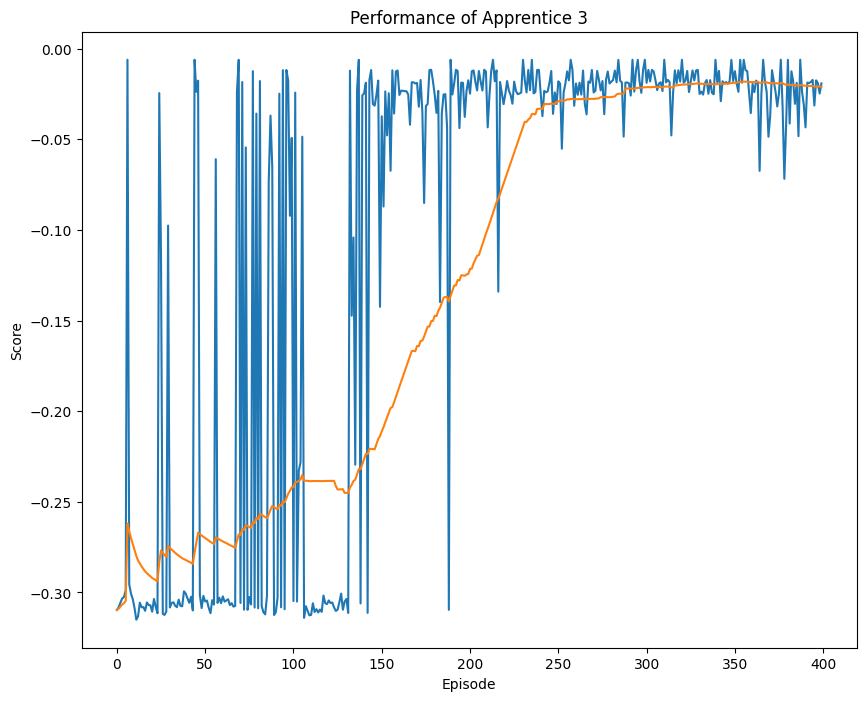

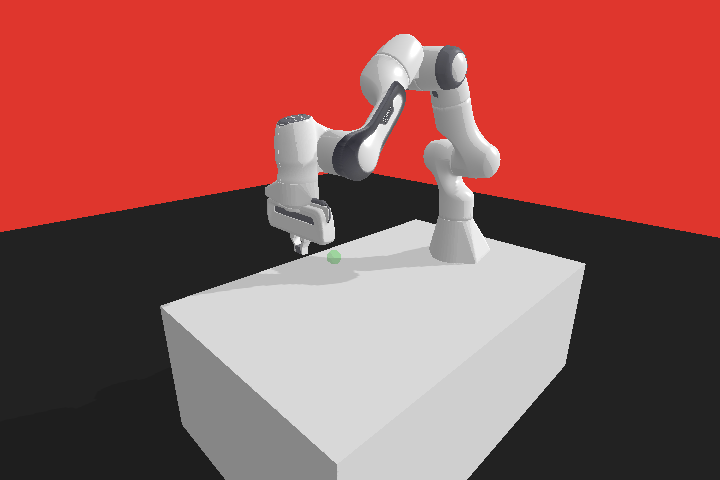

Apprentice 3 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 37.99it/s]


Feature Expectation:  tensor([[ 2.8729e-02,  1.9549e-04,  1.7458e-01, -1.2376e-01, -3.1263e-03,
         -2.1517e-01,  2.8729e-02,  1.9549e-04,  1.7458e-01,  8.8532e-03,
          6.5522e-03,  1.4951e-01]], device='cuda:0')

Average Reward:  -2.142


-------------------------------------- Iteration: 4 --------------------------------------

Margin: 0.015979716554284096
Weight: tensor([[-0.0037],
        [-0.0020],
        [ 0.0030],
        [ 0.0036],
        [ 0.0008],
        [-0.0098],
        [-0.0037],
        [-0.0020],
        [ 0.0030],
        [ 0.0017],
        [-0.0089],
        [ 0.0030]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:52<00:00,  7.67it/s]


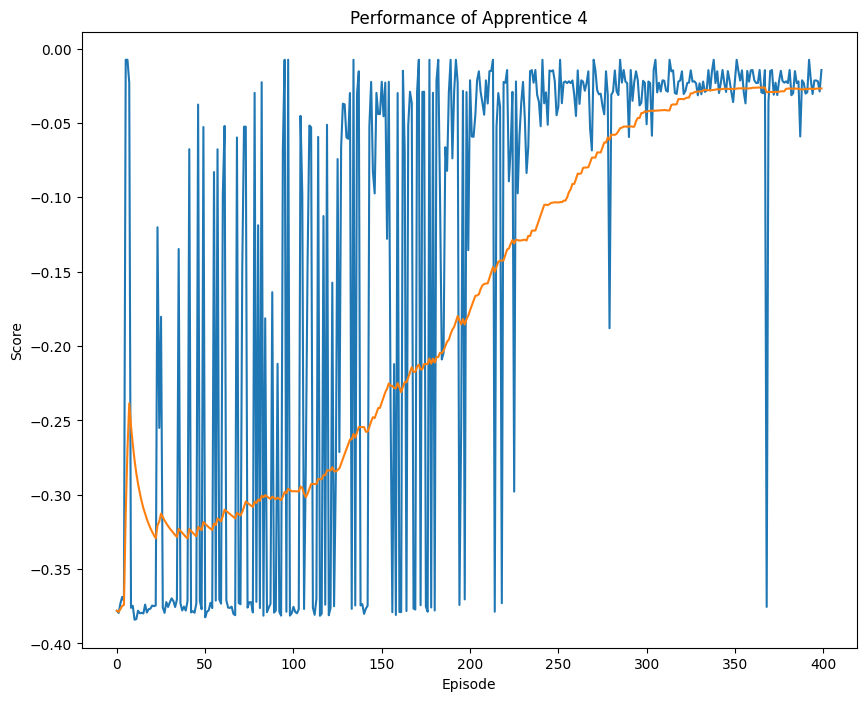

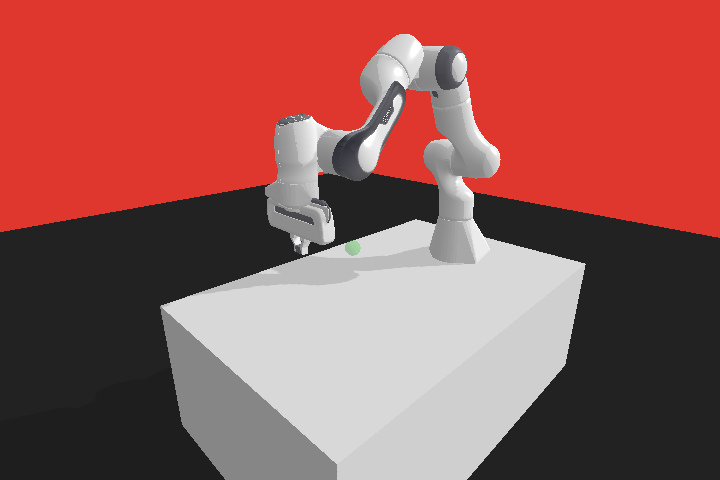

Apprentice 4 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 38.43it/s]


Feature Expectation:  tensor([[ 2.8580e-02,  2.7006e-03,  1.7089e-01, -1.9008e-01, -5.9513e-03,
         -2.8409e-01,  2.8580e-02,  2.7006e-03,  1.7089e-01,  4.5511e-03,
         -2.0498e-05,  1.5163e-01]], device='cuda:0')

Average Reward:  -2.136


-------------------------------------- Iteration: 5 --------------------------------------

Margin: 0.012303361669182777
Weight: tensor([[-4.1411e-03],
        [-2.3273e-03],
        [ 3.2403e-03],
        [ 1.7947e-03],
        [ 4.1731e-03],
        [-6.8316e-04],
        [-4.1411e-03],
        [-2.3273e-03],
        [ 3.2403e-03],
        [ 2.7366e-05],
        [-7.4632e-03],
        [ 2.9054e-03]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:07<00:00,  5.94it/s]


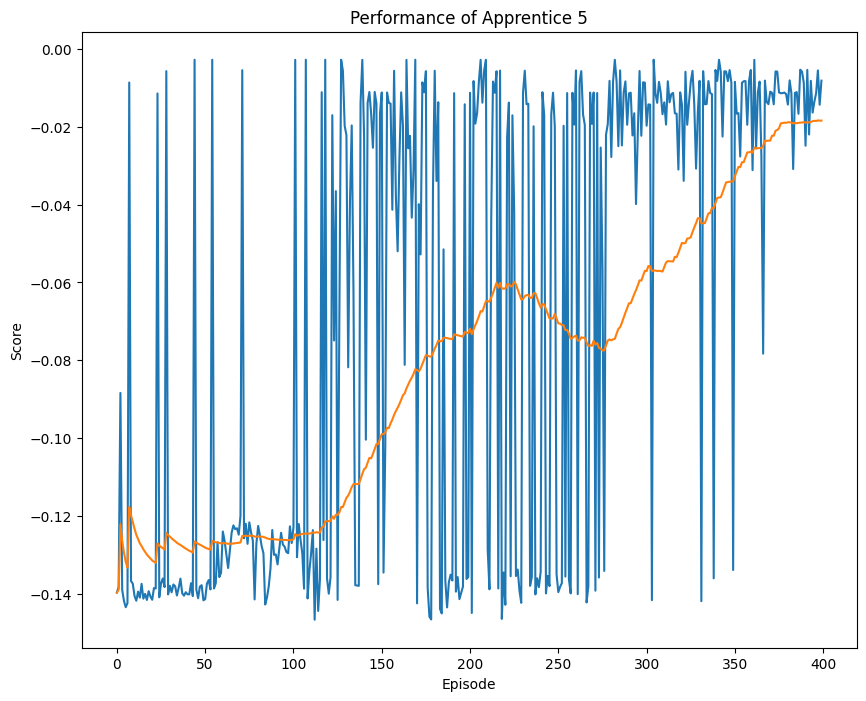

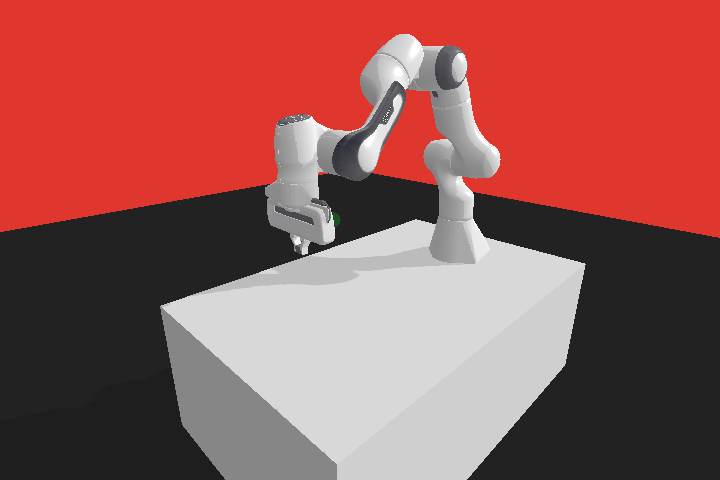

Apprentice 5 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:14<00:00, 34.18it/s]


Feature Expectation:  tensor([[ 0.0202,  0.0051,  0.1795, -0.1539,  0.0192, -0.2202,  0.0202,  0.0051,
          0.1795,  0.0032,  0.0023,  0.1496]], device='cuda:0')

Average Reward:  -3.43


-------------------------------------- Iteration: 6 --------------------------------------

Margin: 0.011713068000972271
Weight: tensor([[-0.0037],
        [-0.0026],
        [ 0.0027],
        [-0.0010],
        [ 0.0033],
        [-0.0028],
        [-0.0037],
        [-0.0026],
        [ 0.0027],
        [-0.0002],
        [-0.0073],
        [ 0.0030]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:55<00:00,  7.18it/s]


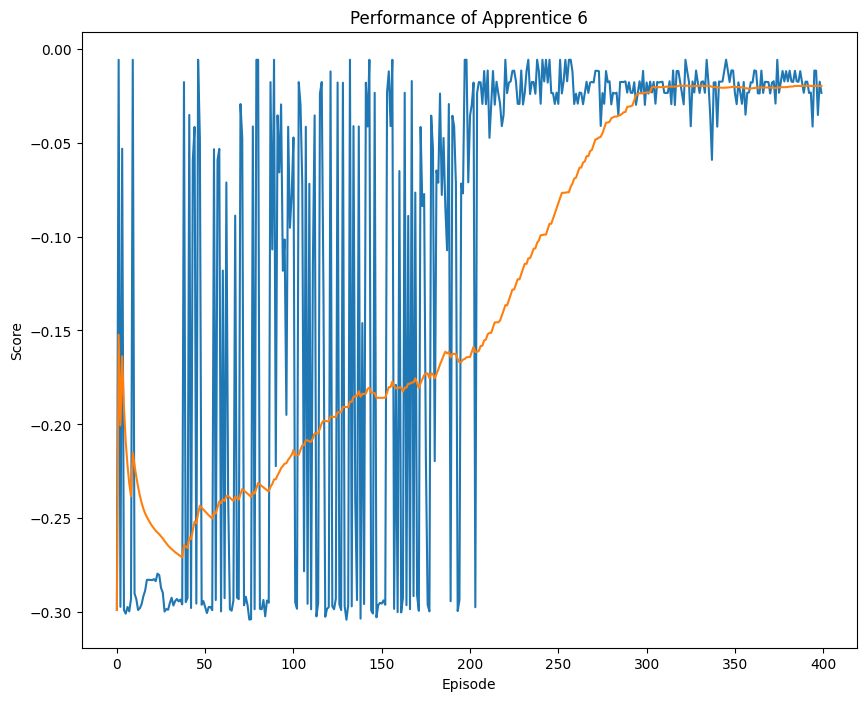

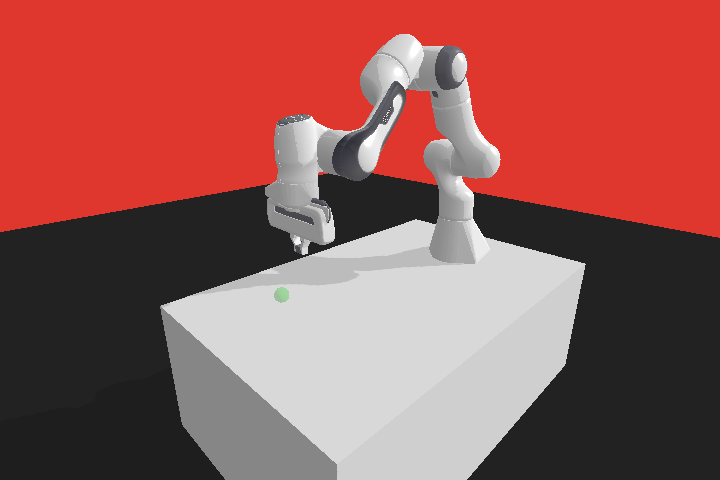

Apprentice 6 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 38.35it/s]


Feature Expectation:  tensor([[ 0.0201,  0.0020,  0.1754, -0.1833,  0.0118, -0.1760,  0.0201,  0.0020,
          0.1754, -0.0017,  0.0030,  0.1437]], device='cuda:0')

Average Reward:  -2.38


-------------------------------------- Iteration: 7 --------------------------------------

Margin: 0.01155460812151432
Weight: tensor([[-0.0039],
        [-0.0026],
        [ 0.0028],
        [-0.0007],
        [ 0.0034],
        [-0.0009],
        [-0.0039],
        [-0.0026],
        [ 0.0028],
        [-0.0003],
        [-0.0073],
        [ 0.0028]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:53<00:00,  7.43it/s]


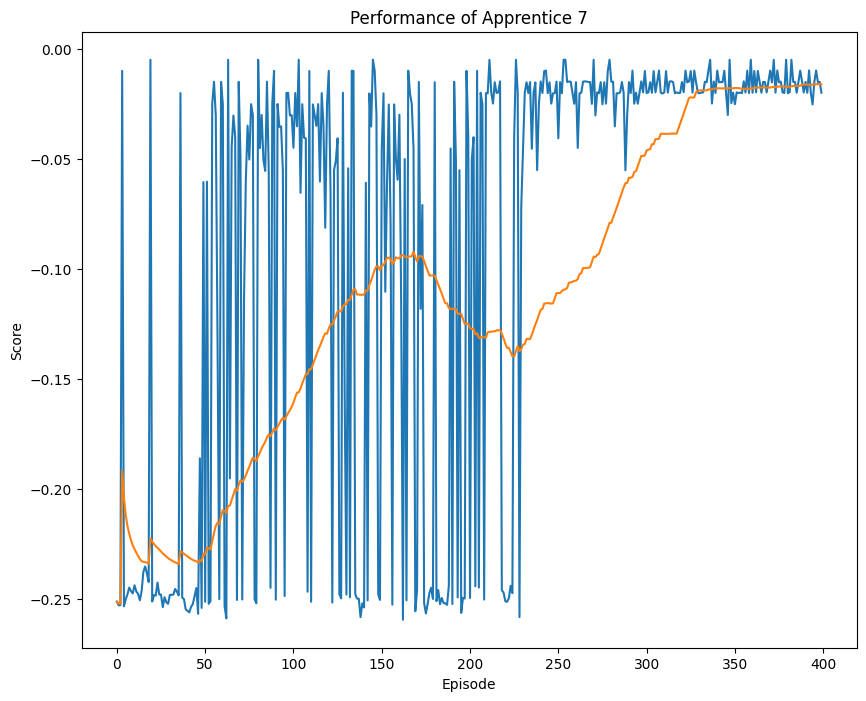

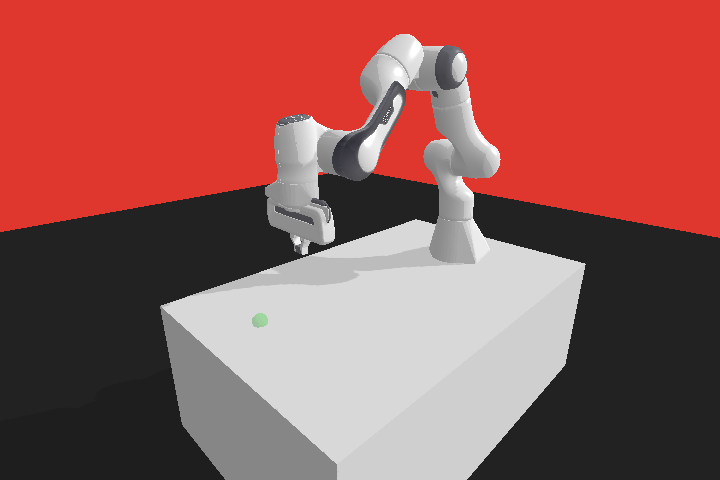

Apprentice 7 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:12<00:00, 41.61it/s]


Feature Expectation:  tensor([[ 0.0227, -0.0008,  0.1713, -0.2015,  0.0248, -0.3015,  0.0227, -0.0008,
          0.1713,  0.0017, -0.0007,  0.1440]], device='cuda:0')

Average Reward:  -2.03


-------------------------------------- Iteration: 8 --------------------------------------

Margin: 0.011105740442872047
Weight: tensor([[-0.0036],
        [-0.0024],
        [ 0.0029],
        [-0.0003],
        [ 0.0023],
        [ 0.0019],
        [-0.0036],
        [-0.0024],
        [ 0.0029],
        [-0.0004],
        [-0.0070],
        [ 0.0033]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:02<00:00,  6.36it/s]


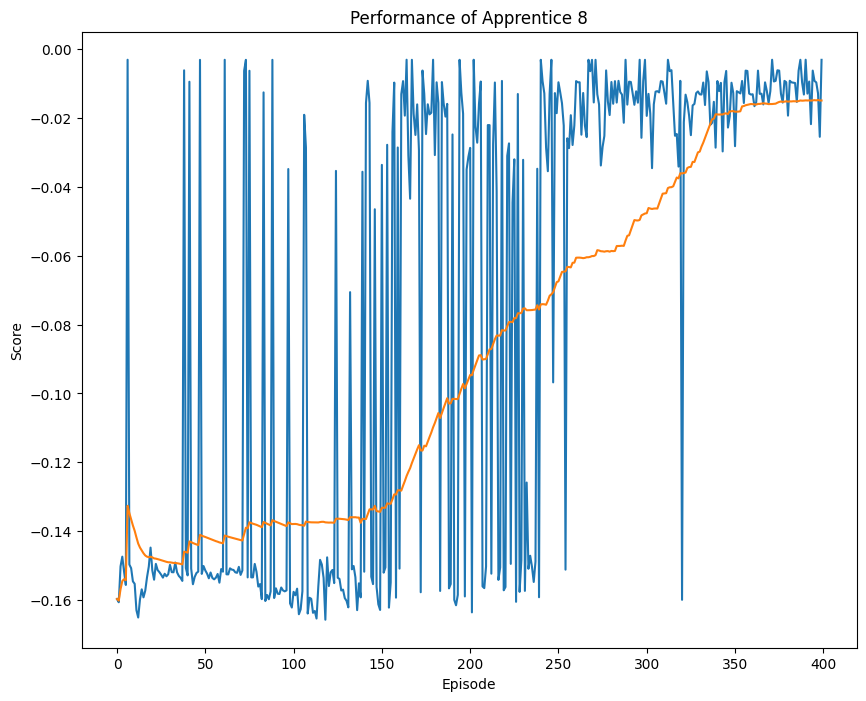

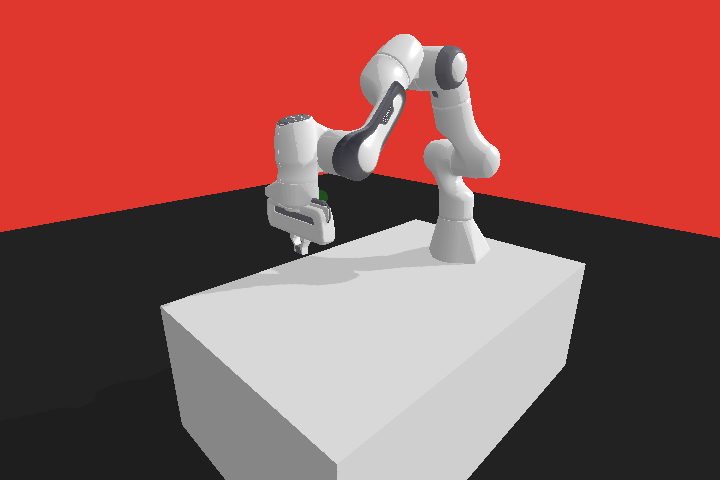

Apprentice 8 Reward:  -2.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 37.86it/s]


Feature Expectation:  tensor([[ 0.0166, -0.0050,  0.1752, -0.1792, -0.0056, -0.1572,  0.0166, -0.0050,
          0.1752,  0.0013,  0.0048,  0.1569]], device='cuda:0')

Average Reward:  -2.332


-------------------------------------- Iteration: 9 --------------------------------------

Margin: 0.010722117498517036
Weight: tensor([[-0.0033],
        [-0.0022],
        [ 0.0028],
        [-0.0007],
        [ 0.0027],
        [-0.0008],
        [-0.0033],
        [-0.0022],
        [ 0.0028],
        [-0.0005],
        [-0.0070],
        [ 0.0031]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:03<00:00,  6.30it/s]


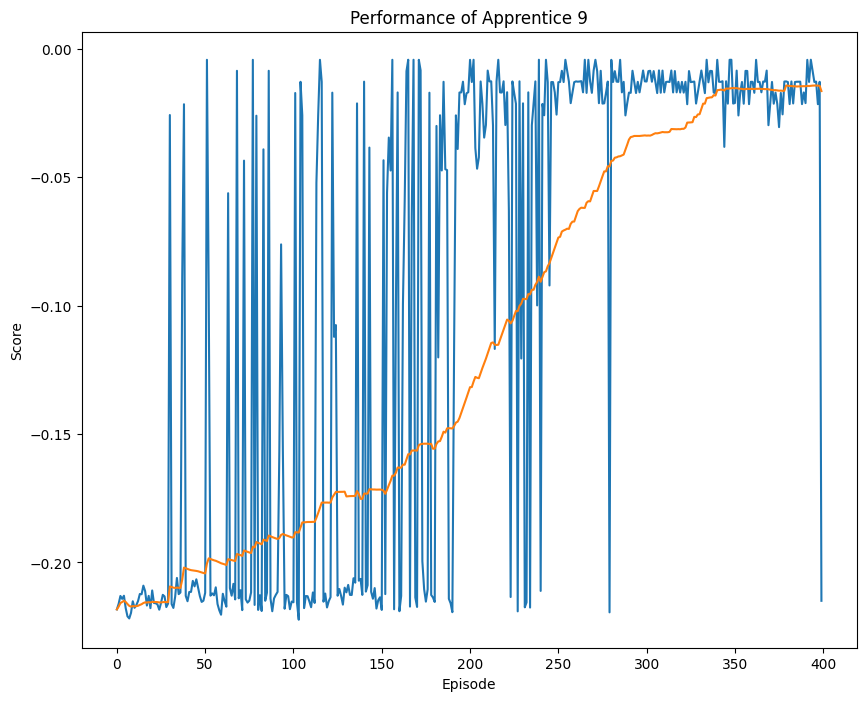

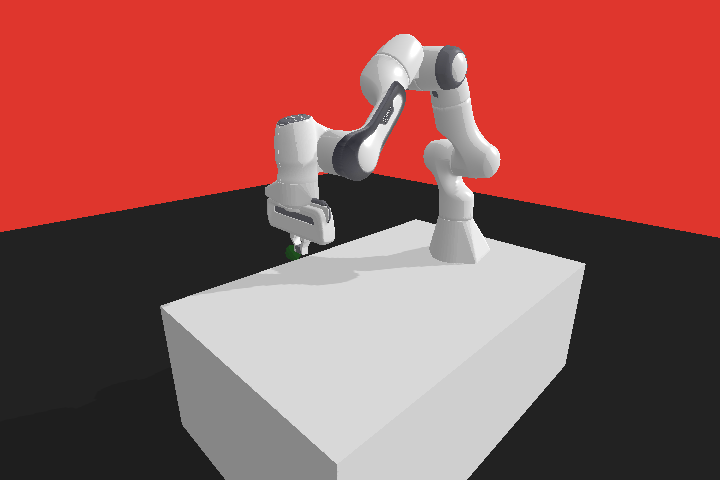

Apprentice 9 Reward:  0.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:30<00:00, 16.39it/s]


Feature Expectation:  tensor([[ 0.0194,  0.0149,  0.2080,  0.0016,  0.0143,  0.1182,  0.0194,  0.0149,
          0.2080,  0.0023, -0.0009,  0.1494]], device='cuda:0')

Average Reward:  -29.54


-------------------------------------- Iteration: 10 --------------------------------------

Margin: 0.010710101574659348
Weight: tensor([[-0.0033],
        [-0.0022],
        [ 0.0028],
        [-0.0005],
        [ 0.0027],
        [-0.0004],
        [-0.0033],
        [-0.0022],
        [ 0.0028],
        [-0.0005],
        [-0.0070],
        [ 0.0031]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:57<00:00,  6.97it/s]


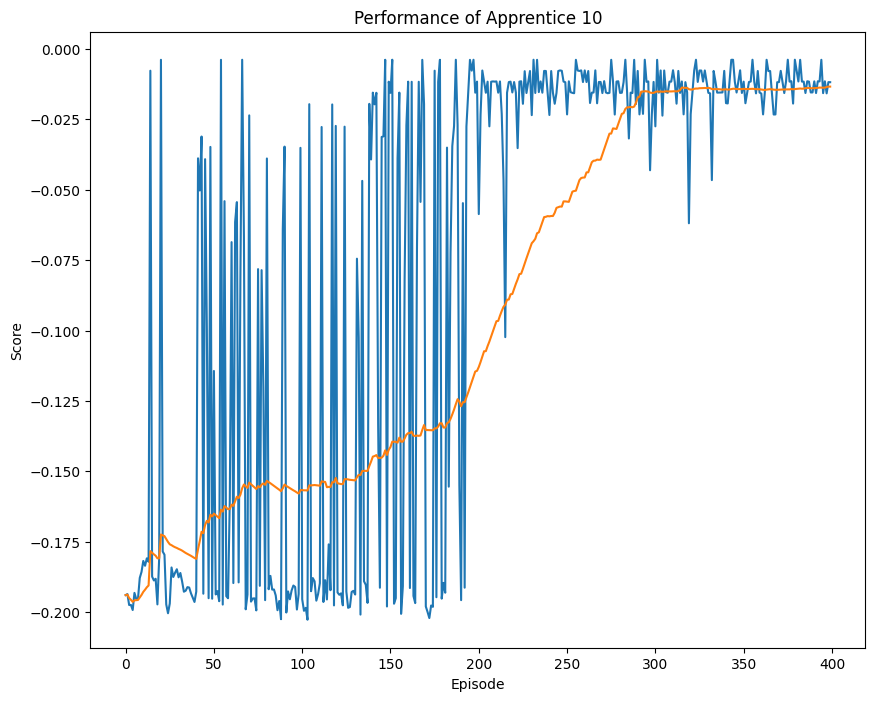

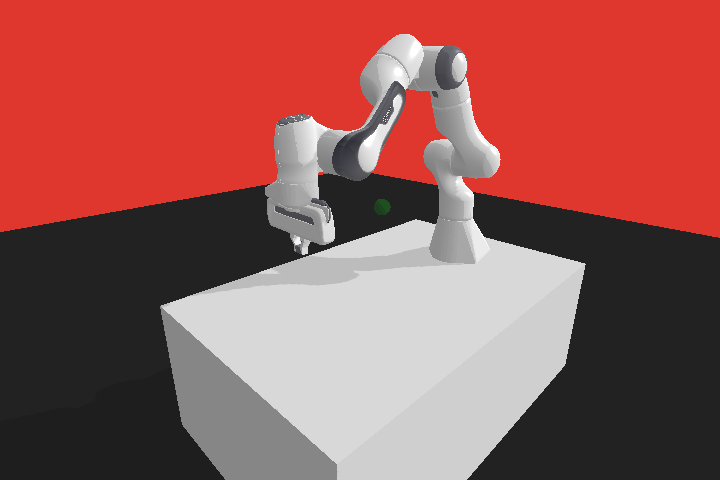

Apprentice 10 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 38.02it/s]



Feature Expectation:  tensor([[ 0.0194, -0.0028,  0.1752, -0.1903,  0.0055, -0.1813,  0.0194, -0.0028,
          0.1752,  0.0014, -0.0020,  0.1441]], device='cuda:0')

Average Reward:  -2.222


-------------------------------------- Iteration: 11 --------------------------------------

Margin: 0.010667400434613228
Weight: tensor([[-0.0032],
        [-0.0022],
        [ 0.0028],
        [-0.0005],
        [ 0.0027],
        [-0.0013],
        [-0.0032],
        [-0.0022],
        [ 0.0028],
        [-0.0005],
        [-0.0069],
        [ 0.0032]], device='cuda:0')


Training..: 100%|██████████| 400/400 [00:53<00:00,  7.48it/s]


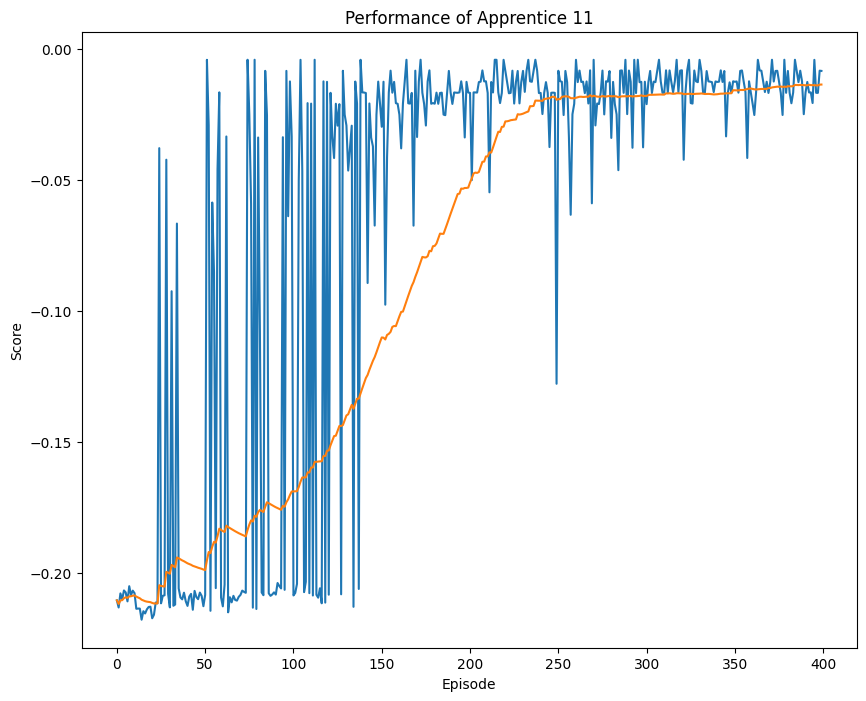

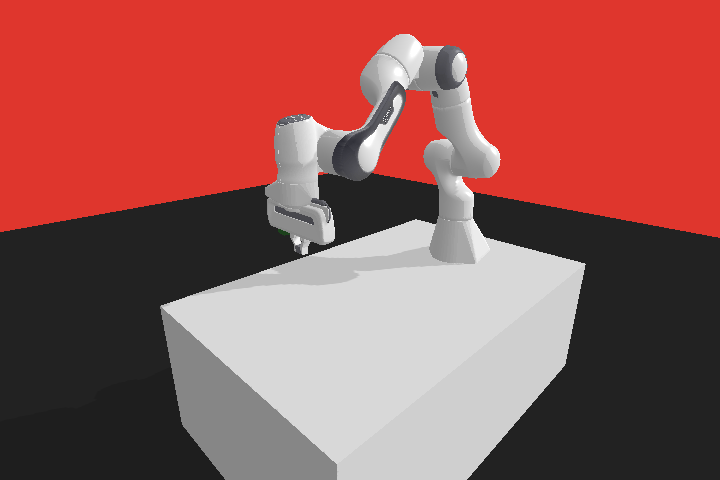

Apprentice 11 Reward:  -1.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 37.22it/s]


Feature Expectation:  tensor([[ 2.0276e-02, -4.8608e-03,  1.8012e-01, -1.9959e-01, -4.7298e-02,
         -2.0830e-01,  2.0276e-02, -4.8608e-03,  1.8012e-01, -1.3356e-04,
         -4.1868e-03,  1.4833e-01]], device='cuda:0')

Average Reward:  -2.688


-------------------------------------- Iteration: 12 --------------------------------------

Margin: 0.01065092533826828
Weight: tensor([[-0.0033],
        [-0.0022],
        [ 0.0029],
        [-0.0006],
        [ 0.0023],
        [-0.0010],
        [-0.0033],
        [-0.0022],
        [ 0.0029],
        [-0.0005],
        [-0.0070],
        [ 0.0032]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:51<00:00,  7.74it/s]


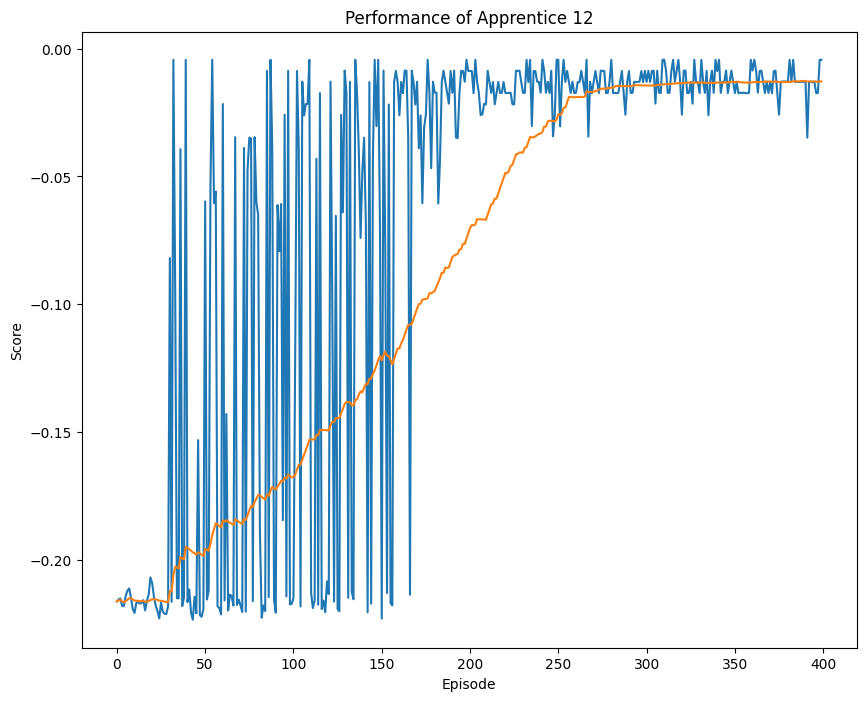

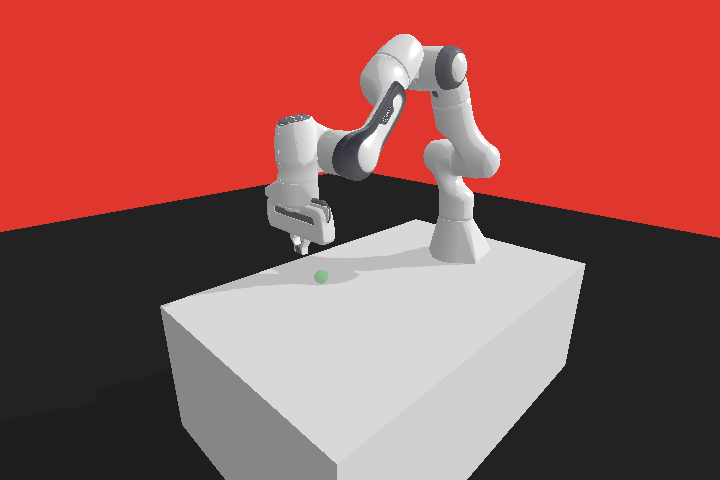

Apprentice 12 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 37.99it/s]


Feature Expectation:  tensor([[ 0.0215, -0.0033,  0.1700, -0.2101, -0.0141, -0.2836,  0.0215, -0.0033,
          0.1700,  0.0065, -0.0029,  0.1457]], device='cuda:0')

Average Reward:  -1.968


-------------------------------------- Iteration: 13 --------------------------------------

Margin: 0.010559498332440853
Weight: tensor([[-3.1297e-03],
        [-2.0537e-03],
        [ 2.9327e-03],
        [-6.5818e-05],
        [ 2.9612e-03],
        [ 2.0474e-05],
        [-3.1297e-03],
        [-2.0537e-03],
        [ 2.9327e-03],
        [-7.1677e-04],
        [-6.7647e-03],
        [ 3.3508e-03]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:08<00:00,  5.83it/s]


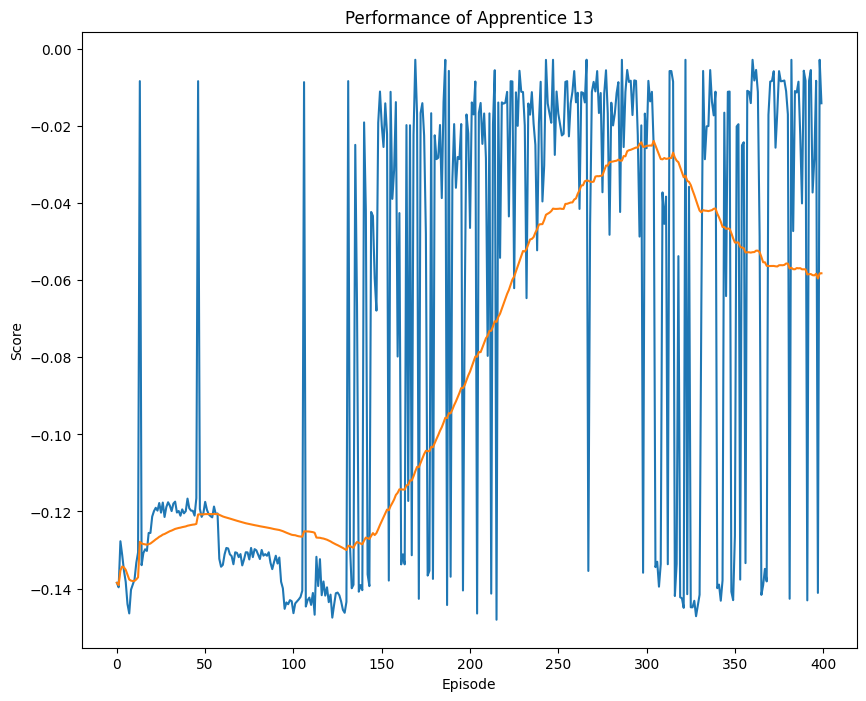

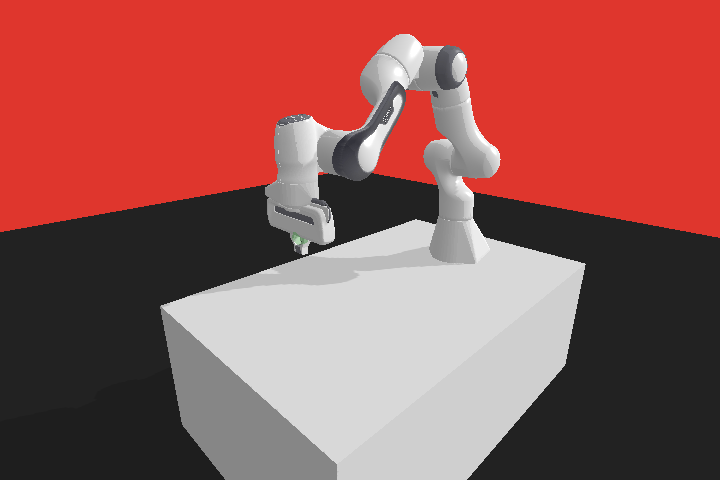

Apprentice 13 Reward:  0.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:15<00:00, 32.05it/s]


Feature Expectation:  tensor([[ 0.0257, -0.0097,  0.1551, -0.1662, -0.0580, -0.1421,  0.0257, -0.0097,
          0.1551,  0.0085, -0.0004,  0.1575]], device='cuda:0')

Average Reward:  -7.616


-------------------------------------- Iteration: 14 --------------------------------------

Margin: 0.010459200479090214
Weight: tensor([[-0.0031],
        [-0.0022],
        [ 0.0027],
        [ 0.0002],
        [ 0.0023],
        [ 0.0012],
        [-0.0031],
        [-0.0022],
        [ 0.0027],
        [-0.0006],
        [-0.0068],
        [ 0.0034]], device='cuda:0')



Training..: 100%|██████████| 400/400 [01:32<00:00,  4.32it/s]


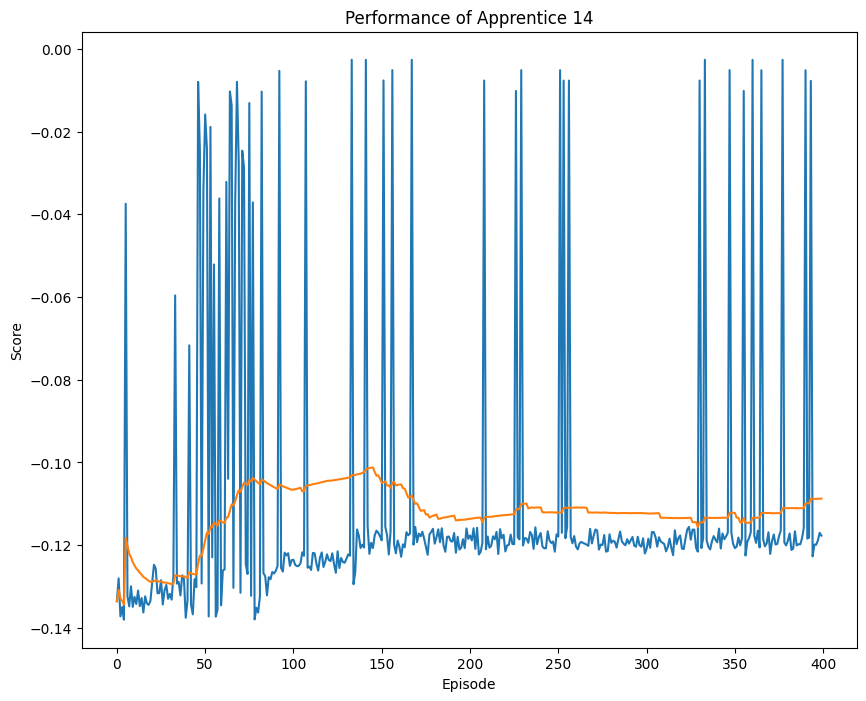

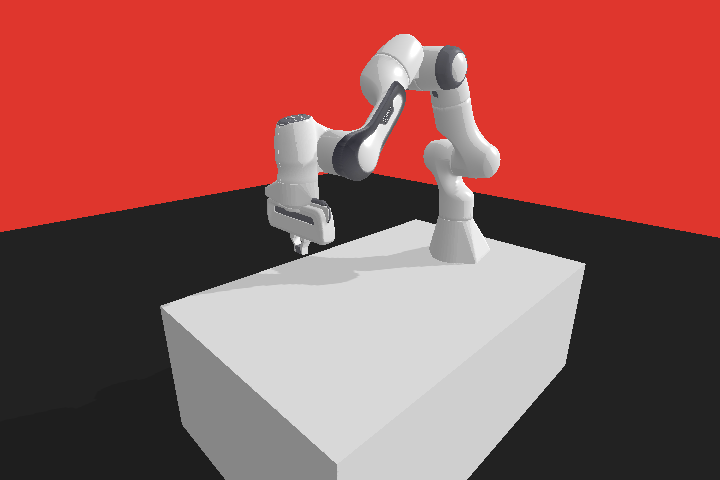

Apprentice 14 Reward:  -50.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:47<00:00, 10.45it/s]


Feature Expectation:  tensor([[-0.6584,  0.4091,  0.5283, -0.2744,  0.1833,  0.1645, -0.6584,  0.4091,
          0.5283,  0.0068,  0.0010,  0.1503]], device='cuda:0')

Average Reward:  -47.06


-------------------------------------- Iteration: 15 --------------------------------------

Margin: 0.009627895429730415
Weight: tensor([[-1.0119e-03],
        [-3.4347e-03],
        [ 1.6456e-03],
        [ 4.8515e-04],
        [ 1.7218e-03],
        [-8.6099e-05],
        [-1.0119e-03],
        [-3.4347e-03],
        [ 1.6456e-03],
        [-6.4460e-04],
        [-6.8045e-03],
        [ 3.4226e-03]], device='cuda:0')



Training..: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]


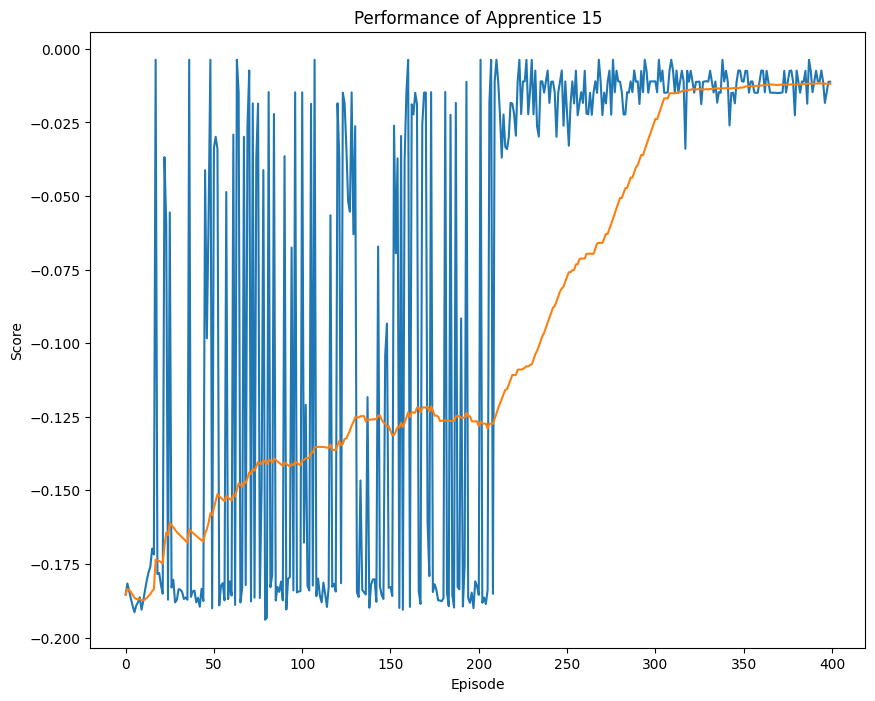

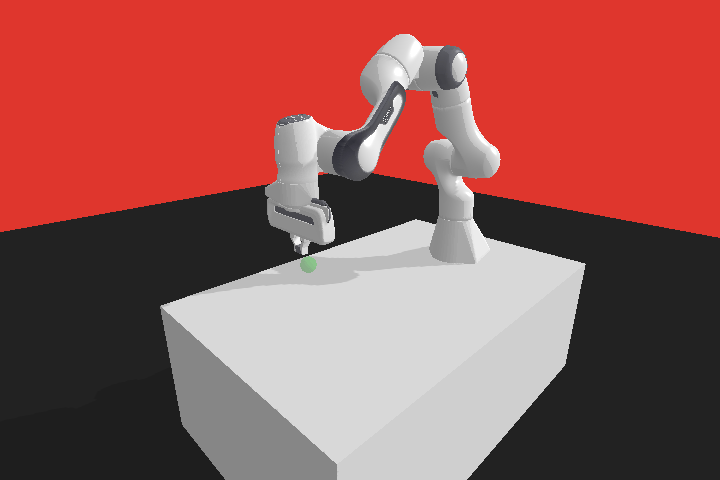

Apprentice 15 Reward:  0.0


Calculating Average Feature Vector and Reward: 100%|██████████| 500/500 [00:13<00:00, 36.50it/s]


Feature Expectation:  tensor([[ 0.0242,  0.0015,  0.1736, -0.1799, -0.0145, -0.2726,  0.0242,  0.0015,
          0.1736,  0.0050,  0.0017,  0.1518]], device='cuda:0')

Average Reward:  -2.02


-------------------------------------- Iteration: 16 --------------------------------------

Margin: 0.009626933373510838
Weight: tensor([[-0.0010],
        [-0.0034],
        [ 0.0016],
        [ 0.0005],
        [ 0.0016],
        [-0.0002],
        [-0.0010],
        [-0.0034],
        [ 0.0016],
        [-0.0006],
        [-0.0068],
        [ 0.0034]], device='cuda:0')


In [13]:
rewards, margins = projection_method_algorithm(env, n_episodes=400, m=500, exploration_period=100)

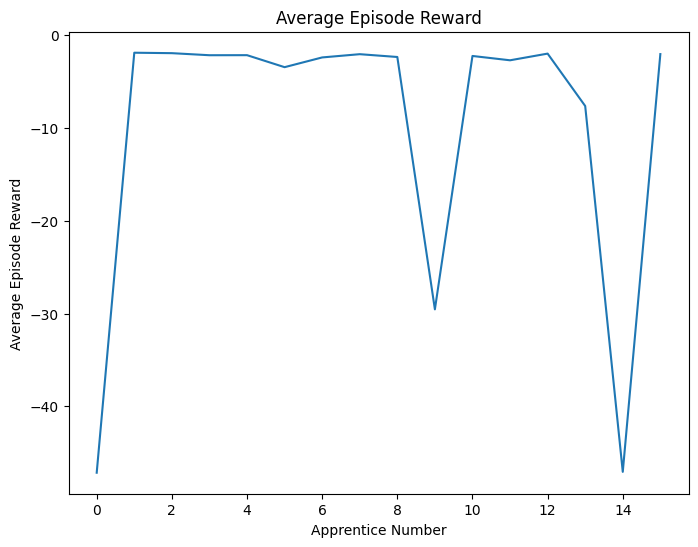

In [14]:
# Performance comparison of apprentices

plt.figure(figsize=(8, 6))
plt.plot(rewards)
plt.title('Average Episode Reward')
plt.xlabel('Apprentice Number')
plt.ylabel('Average Episode Reward')
plt.savefig("../Results/TD3/Apprentice Rewards.png")
plt.show()

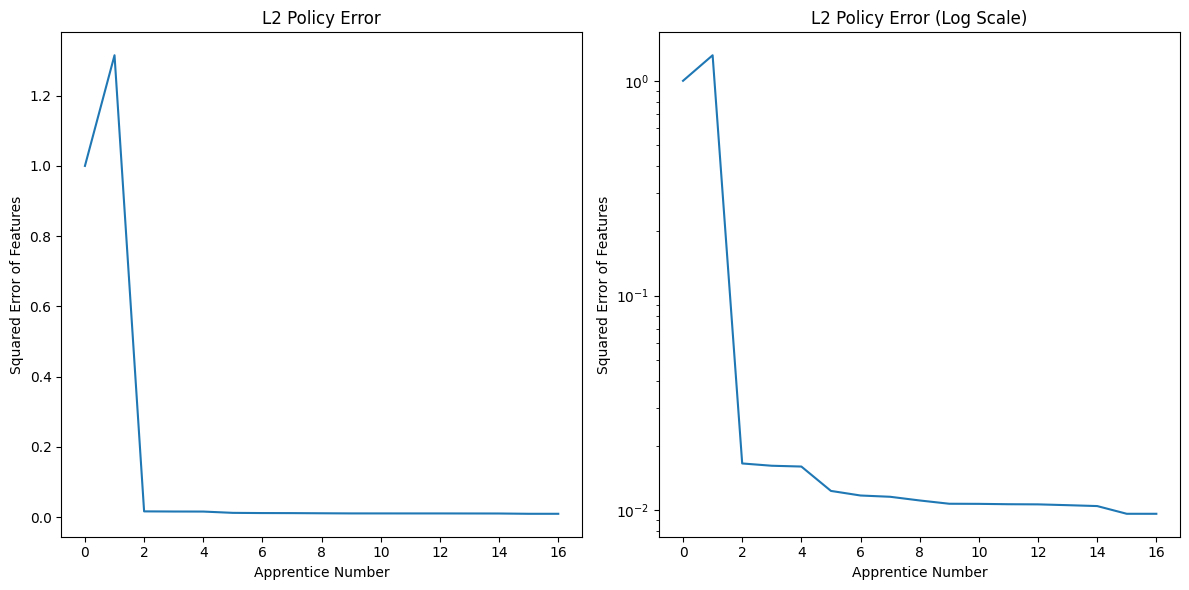

X connection to :0 broken (explicit kill or server shutdown).


: 

In [ ]:
# L2 Policy Error
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot without log scale
axes[0].plot(margins, label="L2 Policy Error")
axes[0].set_title("L2 Policy Error")
axes[0].set_xlabel("Apprentice Number")
axes[0].set_ylabel("Squared Error of Features")

# plot with log scale
axes[1].plot(margins, label="L2 Policy Error")
axes[1].set_title("L2 Policy Error (Log Scale)")
axes[1].set_xlabel("Apprentice Number")
axes[1].set_ylabel("Squared Error of Features")
axes[1].set_yscale("log")

plt.tight_layout()
plt.savefig("../Results/TD3/Apprentice Policy Error.png")
plt.show()